In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in c:\users\bever\anaconda3\envs\pythondata\lib\site-packages (0.0)


In [2]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [29]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Read the CSV and Perform Basic Data Cleaning

In [4]:
df = pd.read_csv(os.path.join("..", "data", "exoplanet_data.csv"))
#" Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Select your features (columns)

In [5]:
# Set features. This will also be used as your x values.
#selected_features = df[['names', 'of', 'selected', 'features', 'here']]
selected_features = df.drop("koi_disposition", axis=1)
selected_features_names = selected_features.columns
selected_features.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,-0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Create a Train Test Split

Use `koi_disposition` for the y values

In [6]:
target = df["koi_disposition"]
target_names = ["CANIDATE", "CONFIRMED","FALSE POSITIVE"]
data = selected_features
data_names = selected_features_names

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [8]:
X_train.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
6122,0,0,0,0,6.768901,7.380000e-05,-7.380000e-05,133.077240,0.008440,-0.008440,...,-171,4.327,0.153,-0.187,1.125,0.310,-0.207,294.40472,39.351681,14.725
6370,0,1,0,1,0.733726,6.060000e-06,-6.060000e-06,132.020050,0.007950,-0.007950,...,-175,4.578,0.033,-0.187,0.797,0.211,-0.056,284.50391,42.463860,15.770
2879,1,0,0,0,7.652707,6.540000e-05,-6.540000e-05,134.460380,0.006190,-0.006190,...,-189,4.481,0.050,-0.200,0.963,0.290,-0.097,295.50211,38.983540,13.099
107,0,0,0,0,7.953547,1.910000e-05,-1.910000e-05,174.662240,0.001820,-0.001820,...,-85,4.536,0.056,-0.016,0.779,0.023,-0.049,291.15878,40.750271,15.660
29,0,0,0,0,4.959319,5.150000e-07,-5.150000e-07,172.258529,0.000083,-0.000083,...,-77,4.359,0.110,-0.110,1.082,0.173,-0.130,292.16705,48.727589,15.263


In [9]:
X_test.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
4982,1,0,0,0,88.523517,2.337000e-03,-2.337000e-03,189.275600,0.023200,-0.023200,...,-75,4.782,0.060,-0.070,0.462,0.050,-0.070,295.57629,48.897861,15.841
4866,0,0,0,0,102.493119,1.322000e-03,-1.322000e-03,166.009400,0.010500,-0.010500,...,-140,4.583,0.024,-0.117,0.791,0.132,-0.055,297.66437,46.944820,15.142
2934,0,0,1,0,1.181165,3.890000e-06,-3.890000e-06,132.425220,0.002760,-0.002760,...,-154,4.582,0.048,-0.078,0.747,0.098,-0.066,291.34879,51.256119,15.971
5007,0,1,0,0,8.412009,2.360000e-07,-2.360000e-07,139.648520,0.000024,-0.000024,...,-206,4.225,0.185,-0.185,1.314,0.373,-0.305,291.84970,37.738621,13.551
3869,0,1,1,1,1.195515,5.730000e-07,-5.730000e-07,132.303851,0.000410,-0.000410,...,-182,4.271,0.220,-0.180,1.155,0.331,-0.271,297.54337,41.947979,13.998


In [10]:
y_train.head()

6122         CANDIDATE
6370    FALSE POSITIVE
2879    FALSE POSITIVE
107          CONFIRMED
29           CANDIDATE
Name: koi_disposition, dtype: object

In [11]:
y_test.head()

4982    FALSE POSITIVE
4866         CANDIDATE
2934    FALSE POSITIVE
5007    FALSE POSITIVE
3869    FALSE POSITIVE
Name: koi_disposition, dtype: object

# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [12]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Train the Model



In [13]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.898741418764302

In [14]:
print(f"Training Data Score: {rf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf.score(X_test_scaled, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.898741418764302


In [15]:
rf

RandomForestClassifier(n_estimators=200)

# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [16]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust

param_grid = {'n_estimators': [50, 100, 150, 250],
              'max_depth': [10, 20, 30, 40],
             'max_features': ['auto', 'sqrt','log2']}
grid = GridSearchCV(rf, param_grid, verbose=3)

In [17]:
# Train the model with GridSearch
grid_result = grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] max_depth=10, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.900, total=   0.4s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.899, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.885, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.870, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.880, total=   0.4s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.898, total=   0.8s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.898, total=   0.8s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.892, total=   0.9s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.879, tot

[CV]  max_depth=10, max_features=log2, n_estimators=250, score=0.891, total=   1.9s
[CV] max_depth=10, max_features=log2, n_estimators=250 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=250, score=0.895, total=   2.1s
[CV] max_depth=10, max_features=log2, n_estimators=250 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=250, score=0.888, total=   2.1s
[CV] max_depth=10, max_features=log2, n_estimators=250 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=250, score=0.876, total=   2.1s
[CV] max_depth=10, max_features=log2, n_estimators=250 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=250, score=0.875, total=   2.3s
[CV] max_depth=20, max_features=auto, n_estimators=50 ................
[CV]  max_depth=20, max_features=auto, n_estimators=50, score=0.904, total=   0.7s
[CV] max_depth=20, max_features=auto, n_estimators=50 ................
[CV]  max_depth=20, max_features=auto, n_estimators=50, score=0.891, to

[CV]  max_depth=20, max_features=log2, n_estimators=100, score=0.872, total=   1.1s
[CV] max_depth=20, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=20, max_features=log2, n_estimators=100, score=0.873, total=   1.1s
[CV] max_depth=20, max_features=log2, n_estimators=150 ...............
[CV]  max_depth=20, max_features=log2, n_estimators=150, score=0.898, total=   1.7s
[CV] max_depth=20, max_features=log2, n_estimators=150 ...............
[CV]  max_depth=20, max_features=log2, n_estimators=150, score=0.898, total=   1.7s
[CV] max_depth=20, max_features=log2, n_estimators=150 ...............
[CV]  max_depth=20, max_features=log2, n_estimators=150, score=0.878, total=   1.7s
[CV] max_depth=20, max_features=log2, n_estimators=150 ...............
[CV]  max_depth=20, max_features=log2, n_estimators=150, score=0.879, total=   1.6s
[CV] max_depth=20, max_features=log2, n_estimators=150 ...............
[CV]  max_depth=20, max_features=log2, n_estimators=150, score=0.876, 

[CV]  max_depth=30, max_features=log2, n_estimators=50, score=0.898, total=   0.6s
[CV] max_depth=30, max_features=log2, n_estimators=50 ................
[CV]  max_depth=30, max_features=log2, n_estimators=50, score=0.891, total=   0.6s
[CV] max_depth=30, max_features=log2, n_estimators=50 ................
[CV]  max_depth=30, max_features=log2, n_estimators=50, score=0.875, total=   0.6s
[CV] max_depth=30, max_features=log2, n_estimators=50 ................
[CV]  max_depth=30, max_features=log2, n_estimators=50, score=0.886, total=   0.6s
[CV] max_depth=30, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=30, max_features=log2, n_estimators=100, score=0.894, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=30, max_features=log2, n_estimators=100, score=0.901, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=100 ...............
[CV]  max_depth=30, max_features=log2, n_estimators=100, score=0.880, tota

[CV]  max_depth=40, max_features=sqrt, n_estimators=150, score=0.882, total=   1.9s
[CV] max_depth=40, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=40, max_features=sqrt, n_estimators=250, score=0.906, total=   3.3s
[CV] max_depth=40, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=40, max_features=sqrt, n_estimators=250, score=0.903, total=   3.2s
[CV] max_depth=40, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=40, max_features=sqrt, n_estimators=250, score=0.887, total=   3.3s
[CV] max_depth=40, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=40, max_features=sqrt, n_estimators=250, score=0.877, total=   3.2s
[CV] max_depth=40, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=40, max_features=sqrt, n_estimators=250, score=0.884, total=   3.1s
[CV] max_depth=40, max_features=log2, n_estimators=50 ................
[CV]  max_depth=40, max_features=log2, n_estimators=50, score=0.899, t

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.1min finished


In [26]:
# Output the grid search best params and best score
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 50}
0.8943310240941937


In [19]:
print(f"Training Data Score: {grid.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {grid.score(X_test_scaled, y_test)}")

Training Data Score: 0.9998092695021934
Testing Data Score: 0.8930205949656751


In [20]:
best_params = grid_result.best_params_
best_params

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 50}

In [21]:
# Found in article https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998
best_params = grid_result.best_params_
best_rf = RandomForestClassifier(max_depth=best_params["max_depth"], max_features=best_params["max_features"], n_estimators=best_params["n_estimators"])
best_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=30, n_estimators=50)

In [22]:
# Output our training and test score.
print(f"Best Random Forest Training Data Score: {best_rf.score(X_train_scaled, y_train)}")
print(f"Best Random Forest Testing Data Score: {best_rf.score(X_test_scaled, y_test)}")

Best Random Forest Training Data Score: 0.9998092695021934
Best Random Forest Testing Data Score: 0.8907322654462243


In [23]:
# Make predictions and calculate classification report
predictions = best_rf.predict(X_test_scaled)
print(classification_report(y_test, predictions,
                            target_names=target_names))

                precision    recall  f1-score   support

      CANIDATE       0.80      0.75      0.78       411
     CONFIRMED       0.83      0.83      0.83       484
FALSE POSITIVE       0.97      0.99      0.98       853

      accuracy                           0.89      1748
     macro avg       0.86      0.86      0.86      1748
  weighted avg       0.89      0.89      0.89      1748



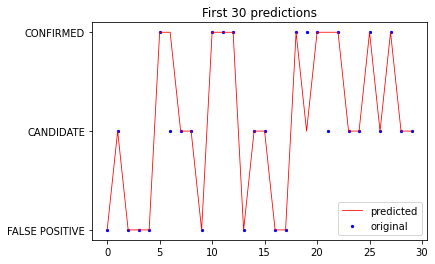

In [35]:
# Create a preduction vs original chart
x_ax = range(len(y_test[:30]))
plt.scatter(x_ax, y_test[:30], s=5, color="blue", label="original")
plt.plot(x_ax, predictions[:30], lw=0.8, color="red", label="predicted")
plt.title('First 30 predictions')
plt.legend()
plt.show()

# Save the Model

In [24]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = os.path.join("..", "models", "model_random_forest.sav")
joblib.dump(best_rf, filename)

['..\\models\\model_random_forest.sav']